# MORO Project Cookbook

This notebook provides an overview of the approaches I took to solve the maze control assignment. You don't have to follow the same approach, however, this documentation serves as a guideline on which steps in the data processing pipeline you will need to solve/implement. You can use any examplatory code-blocks provided in this notebook for your own implementation, however, they have to be treated like any other source and cited in your code.

I will provide plots of the data for each step alongside the source code for the visualisation to give you a starting off point for your own documentation.

## Processing Pipeline Concept

<img src="./material/MoroNotebookFigures-pipeline.drawio.png" width="600">

_Figure 1: Pipelines for global planning using search and local planning using forward simulation._

## Step 1: Loading and Transforming Map from ROS

Once the simulation of the robot in the maze has been started using `roslaunch soarMazeEscape launchSimulation.launch`, we can start loading the map from ROS. The map is available either as a service or as a ROS message. Since we will be needing both the map only once, I have decided to get the map using a ROS service.

The following two codeblock imports neccesary Python modules and defines a helper function for retrieving the map.

In [1]:
# Import neccesary modules
# Set matplotlib to inline mode for the Jupyter notebook visualisations

%matplotlib inline

import rospy
import tf2_ros

from geometry_msgs.msg import Twist, PoseStamped, TransformStamped, Quaternion, Point
from nav_msgs.srv import GetMap
from nav_msgs.msg import OccupancyGrid, Path

import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

import copy
import time
import math

# Helper method for retrieving the map
def getMap() -> OccupancyGrid:
    """ Loads map from map service """
    # Create service proxy
    get_map = rospy.ServiceProxy('static_map', GetMap)
    # Call service
    recMap = get_map()
    recMap = recMap.map
    # Return
    return recMap

# Initiate ROS node
rospy.init_node('moro_maze_navigation')
recMap = getMap()

However, we now receive the map in form of a [nav_msgs:OccupancyGrid](http://docs.ros.org/en/noetic/api/nav_msgs/html/msg/OccupancyGrid.html). The occupancy grid serialises the map as a one-dimensional array, with metadata such as map height, width and resolution being provided. Therefore, we need to first deserialise the one-dimensional array into the correct, two-dimensional format (see [numpy.split()](https://numpy.org/doc/stable/reference/generated/numpy.split.html)). Based on the provided origin as well as the resolution, we can calculate the positions of all points considered free and all points considered walls by the map. The transformation and corresponding formula are depicted in the next figure.

<img src="./material/notebookFigures-mapTransformation.drawio.png" width="600">

_Figure 2: The map needs to be deserialised and transformed into world coordinates for further processing._

In [2]:
# REDACTED CODE BLOCK
## Implements class that deserialises the map into two lists of carthesian coordinates containing global positions of walls and free space

The next codeblock shows a visualisation of the transformed map using matplotlib. `freePositions` and `wallPositions` are lists containing the position of each transformed pixel in the map (representing unobstructed space or walls respectively). For a more in-depth explanation of the code seen here, you can have a look at the [Matplotlib Scatterplot Example](https://matplotlib.org/stable/gallery/shapes_and_collections/scatter.html).

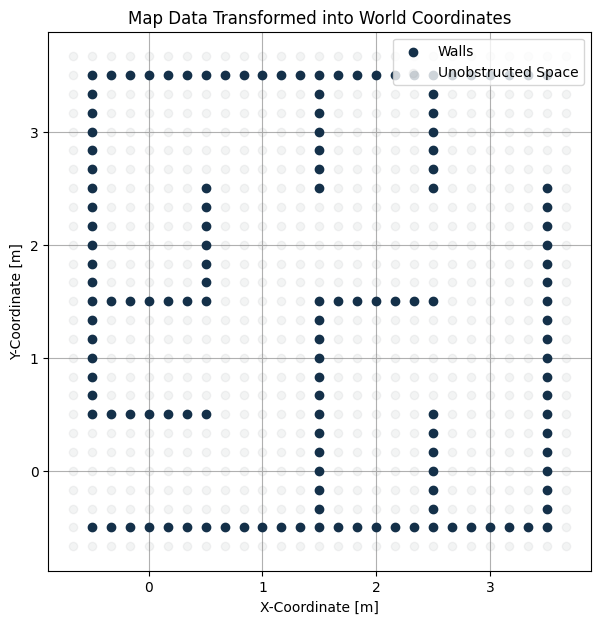

In [3]:
# Store colours matching UAS TW colour scheme as dict 
colourScheme = {
    "darkblue": "#143049",
    "twblue": "#00649C",
    "lightblue": "#8DA3B3",
    "lightgrey": "#CBC0D5",
    "twgrey": "#72777A"
}

## Visualise transformed maze and scans
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Plot data as points (=scatterplot) and label accordingly. The colours are to look nice with UAS TW colours
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(freePositions[:,1], freePositions[:,0], c=colourScheme["twgrey"], alpha=0.08, s=6**2, label="Unobstructed Space")

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Map Data Transformed into World Coordinates")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

## Step 2: Globally Plan Path to Exit

During lesson 4, we have already discussed the concept of search algorithms (see Class 4: Introduction to Search Algorithms for the theory behind search). The idea behind search for global path planning is to represent the map as a graph and have the robot find an arbitrary way or the most optimal way between two nodes. 

### Graph Creation

In order to implement search on a graph, we need to think about how we actually represent the nodes and edges that depict the graph. 

Nodes have these properties:
- Position

Edges have these properties:
- Parent Node
- Child Node
- Cost

The graph is created based on data in the map. However, we have to pay attention how a node's position in world-coordinates correlates with the node's position in the array representing the map. You can solve this problem by either impementing functions that convert coordinates to and from map indices using the map's resolution, or you can use X and y from the previous step as a lookup table. The approach is up to you.

In [4]:
# REDACTED CODE BLOCK
## Implements functions for graph creation and manipulation (see slides regarding search) as well as search

The next code cell prints out part of my generated graph for this problem. I used a list of dictionaries to represent the edges, with node positions being encoded in the node's name. Note, that the encoded node positions *x.y* are on the discrete map. Therefore, they need to be converted to world-coordinates, similarly to the approach presented in Step 1.

In [5]:
print(edges[:10])

[{'parent': '4.4', 'child': '10.4'} {'parent': '4.10', 'child': '10.10'}
 {'parent': '4.16', 'child': '4.22'} {'parent': '4.22', 'child': '10.22'}
 {'parent': '10.4', 'child': '10.10'}
 {'parent': '10.10', 'child': '10.16'}
 {'parent': '10.16', 'child': '16.16'}
 {'parent': '10.16', 'child': '10.22'}
 {'parent': '16.4', 'child': '16.10'}
 {'parent': '16.10', 'child': '22.10'}]


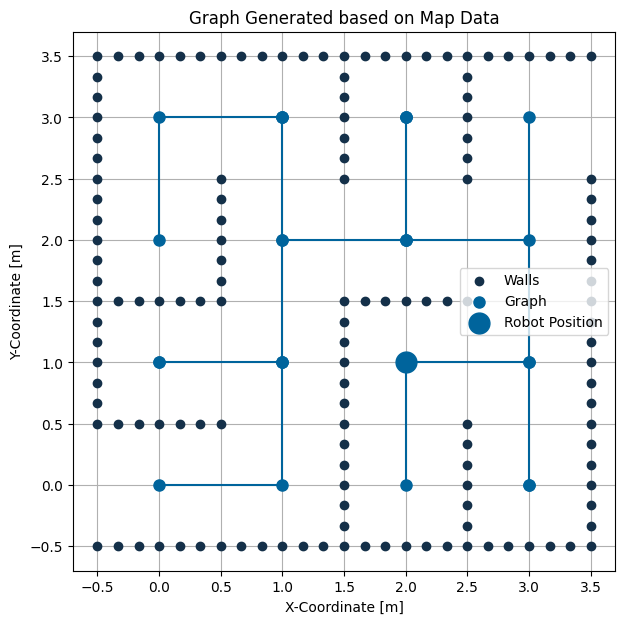

In [6]:
## Visualise maze and generated graph
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Get points on graph
nodePositions = np.array([
    fromNodeName(n["parent"], recMap) for n in edges
] + [
    fromNodeName(n["child"], recMap) for n in edges
])

nodePositions = np.unique(nodePositions, axis=1)

# Get lines connecting the nodes
edgeLines = np.array(
    [
        [
            fromNodeName(n["parent"], recMap),
            fromNodeName(n["child"], recMap)
        ] for n in edges
    ]
)

# Plot data as points (=scatterplot) and label accordingly. The colours are defined to look nice with UAS TW colours
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(nodePositions[:,1], nodePositions[:,0], c=colourScheme["twblue"], alpha=1.0, s=8**2, label="Graph")
ax.scatter([robotPos[1]], [robotPos[0]], c=colourScheme["twblue"], s=15**2, label="Robot Position")

# Plot lines connecting nodes
for line in edgeLines:
    x0, y0 = line[0]
    x1, y1 = line[1]
    x = [x0, x1]
    y = [y0, y1]
    ax.plot(x, y, c=colourScheme["twblue"])

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Graph Generated based on Map Data")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

### Performing Search

Once the map is properly represented as a graph, it is basically compatible with any search algorithm. The utilised algorithm can be chosen from literature (see Russel & Norvig, 1995: Artificial Intelligence: A Modern Approach, Chapter 2.3 for the algorithms). I will provide pseudocode for Breadth-First Search (BFS) and Depth-First-Search (DFS), since those algorithms are also described in the moodle content.

#### Breadth-First Search

- *discoveredNodes* is a list, that keeps track of nodes the search algorithm has already visited.
- *queue* is a list, that keeps track of which nodes we still have to visit.
- *listParents(discoveredNodes)* lists all parents of all nodes in discoveredNodes.
- *getChildren(graph, node)* lists all children of node on the graph representing the map.
- *pop* means removing the last element of a queue.

```python

discoveredNodes = []

def BFS(currentNode, graph, goal)
    Add currentNode to queue
    while queue not empty:
        n = queue.pop
        if n == goal: return
        for child in getChildren(graph, n):
            if child not in listParents(discoveredNodes):
                add new edge from n to child to discoveredNodes
                add child to queue
```

#### Depth-First Search

- *discoveredNodes* is a list, that keeps track of nodes the search algorithm has already visited.
- *listChildren(discoveredNodes)* lists all children of all nodes in discoveredNodes.
- *getChildren(graph, currentNode)* lists all children of currentNode on the graph representing the map.


```python

discoveredNodes = []

def DFS(currentNode, graph, goal):
    Add currentNode to discoveredNodes
    if goal == currentNode: return
    for child in getChildren(graph, currentNode):
        if child in listChildren(discoveredNodes):
            DFS(node, goal)
```

### Path Reconstruction

Both of these search algorithms return *discoveredNodes*. This is a list containing all nodes the algorithm has traversed during search. In the final step, we need to reconstruct the path from this list of nodes. Due to the nature of the search algorithms, we can assume that (as long as the search was successful), *discoveredNodes* contains our specified start, goal and exactly one path between them. Furthermore, the list presents its own graph, which looks like a tree: starting from any other node on the list, we can traverse from child to parent and will always end up at the startnode. This principle is presented in the next figure.

<img src="./material/notebookFigures-searchTransformation.drawio.png" width="600">

_Figure: This example simulates search on an exemplary graph from node N1 to node N8. The resulting graph after search is shaped like a tree, with all branches leading to the start of the search. Each node is connected to the startnode by one path._

The final step in our implementation is to reconstruct the path by iterating over each node's parent, starting from the goal in *discoveredNodes*. We note each traversed node and calculate its position in world coordinates (i.e. the reverse of the transformation presented in Step 1).

The next block calls the search algorithm based on the graph and determined robot position. Finally, the path is reconstructed from the transformed graph.

In [7]:
# REDACTED CODE BLOCK
## Performs search on the generated graph

Found Path: [array([2., 1.]), array([3., 1.]), array([3., 2.]), array([3., 3.])]


We can now visualise the found robot position, path, maze and laserscan similarly to what RViz will display.

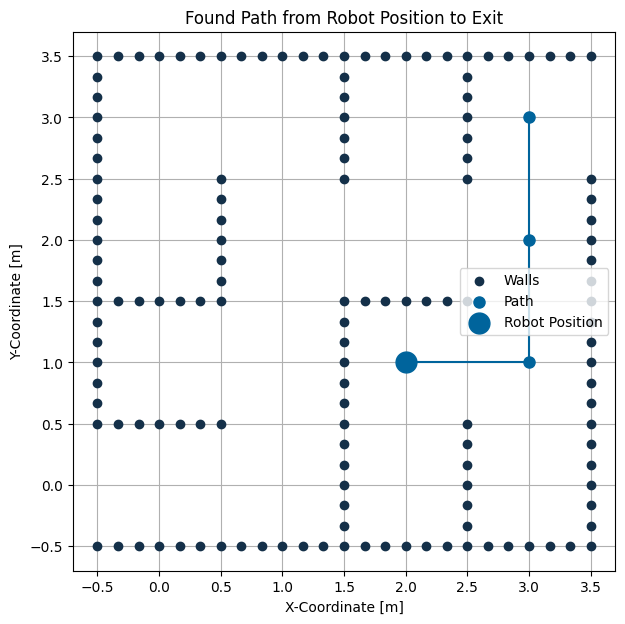

In [8]:
## Visualise maze and found path
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

## Format found path
# Get points on path
nodePositions = np.array([
    fromNodeName(n, recMap) for n in path
])

# Get lines connecting the nodes
edgeLines = np.array(
    [
        [
            fromNodeName(path[idx-1], recMap),
            fromNodeName(path[idx], recMap)
        ] for idx in range(1, len(path))
    ]
)

# Plot data as points (=scatterplot) and label accordingly. The colours are defined to look nice with UAS TW colours
ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
ax.scatter(nodePositions[:,0], nodePositions[:,1], c=colourScheme["twblue"], alpha=1.0, s=8**2, label="Path")
ax.scatter([robotPos[1]], [robotPos[0]], c=colourScheme["twblue"], s=15**2, label="Robot Position")

# Plot lines connecting nodes
for line in edgeLines:
    x0, y0 = line[0]
    x1, y1 = line[1]
    x = [x0, x1]
    y = [y0, y1]
    ax.plot(x, y, c=colourScheme["twblue"])

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Found Path from Robot Position to Exit")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

## Step 3: Locally Navigate Along Global Path

Resulting from previous steps, we now have a trajectory from the robot's starting pose to one of the exits. For debugging purposes, let us temporarily hard-code the path. For the remainder of the cookbook, the path will be given in form $(x,y,\theta)$ in world coordinates to adhere to the pose format used in the self-learning sections. The poses are provided in the "map" coordinate frame.

The robot will need to sequentially target all goalposes outlined by the global path. However, it may be easier to debug the data processing pipeline with a single goal. Therefore, the goal is set to the first goalpose until the last step of this notebook, where all components are integrated into a control loop.

_**Note:** The path used to demonstrate the control sections of the notebook is manually set to be more complex than the path found by the search algorithm. This is for demonstration purposes and is not a requirement for the project._

**For the final submission, _global_path_ must be generated from the global path found by the search algorithm.**

In [9]:
## Imports required components and manually creates a complex global path for debugging
import numpy as np

global_path = [
    [2.5 ,1, 0],
    [3, 1.5, 0.5*np.pi],
    [2.5, 2, np.pi],
    [1.5, 2, np.pi],
    [1, 1.5, 1.5*np.pi],
    [1, 0.5, 1.5*np.pi],
    [0.5, 0, np.pi],
    [0, 0, np.pi],
]

current_goal_ID = 1

print(f"Current goalpose for debugging: {global_path[current_goal_ID]}")

Current goalpose for debugging: [3, 1.5, 1.5707963267948966]


Local planning is split into the following four sections.

1. **Determine Movement Goal Relative to Robot**: Compares the robot's pose to the current goalpose on the global path to determine where the robot should navigate next.
2. **Generate Valid Control Signals**: Generates a set of command velocities that potentially bring the robot closer to its current goal.
3. **Simulate Outcome of Control Signals**: Perform forward simulation to guess whether or not a command velocity moves the robot closer to its current goal.
4. **Publish to ROS**: Publish the expected best control velocity and the estimated trajectory to ROS.

## Determine Movement Goal Relative to Robot

It is recommended to refer back to the " 2DTransformationsROS" notebook and the "Mobile Robotics with ROS" self-learning for this section.

The current robot pose can be queried from ROS' internal transformation system. In order to do so, we need `Buffer` and `TransformListener` objects from the `tf2_ros` module. This module only functions properly, after a ROS node has been initialised. In order to get the transform from map to robot, the `lookup_transform` method from the `Buffer` object is used to load the latest transform from the "map" to the "base_link" coordinate systems. 

ROS natively provides transforms as *geometry_msgs/TransformStamped* messages, which represent rotations in $3D$ using quaternions. Therefore, the transform's rotation component is converted to euler angles and projected onto the $xy$ plane using the [SciPy spatial module](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html#scipy.spatial.transform.Rotation). This is done by the following block:

```python
theta = R.from_quat([
    trans.transform.rotation.x,
    trans.transform.rotation.y,
    trans.transform.rotation.z,
    trans.transform.rotation.w]).as_euler("xyz")[2]
```

`R.from_quat` loads a rotation from a quaternion (in form $x$, $y$, $z$, $w$). The rotation is then converted to euler angles using `as_euler("xyz")`. Since this application is only concerned with the rotation around the $z$ axis (=$\theta$), only the second component `[2]` of the resulting array is stored.

In [10]:
## Initialises a ROS node and required transform buffer objects for robot localisation
import rospy
import tf2_ros

from scipy.spatial.transform import Rotation as R

try:
    rospy.init_node("local_planner") # <- If not already initialised, create your node here
except: pass

tfBuffer = tf2_ros.Buffer()
listener = tf2_ros.TransformListener(tfBuffer)

In [11]:
def localiseRobot():
    """Localises the robot towards the 'map' coordinate frame. Returns pose in format (x,y,theta)"""
    while True:
        try:
            trans = tfBuffer.lookup_transform('map', 'base_link', rospy.Time(0), rospy.Duration(1.0))
            break
        except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException):
            print("Robot localisation took longer than 1 sec")
            continue

    theta = R.from_quat([
        trans.transform.rotation.x,
        trans.transform.rotation.y,
        trans.transform.rotation.z,
        trans.transform.rotation.w]).as_euler("xyz")[2]
    
    return np.array([
        trans.transform.translation.x,
        trans.transform.translation.y,
        theta])

In [12]:
robotpose = localiseRobot()
print(robotpose)

[2.00000287 1.00041281 0.00617626]


The following cell visualises the global path (grey line) as well as the poses that define the global path (blue arrows). 

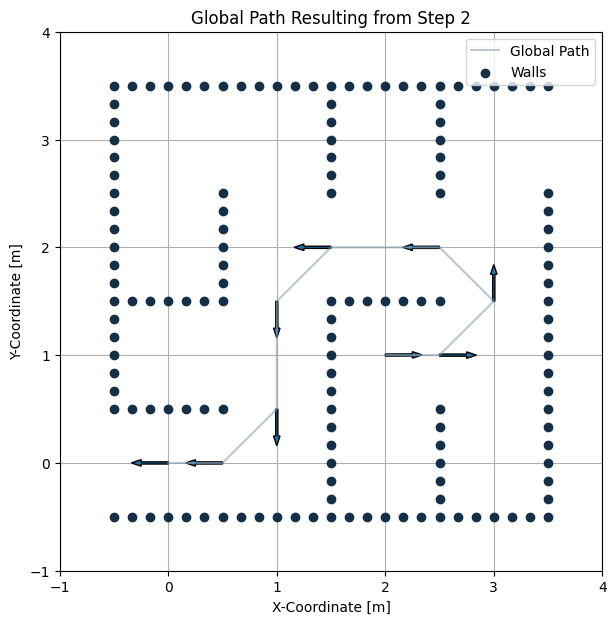

In [13]:
## Visualises global path and poses along the path in the transformed map
import matplotlib.pyplot as plt

# Store colours matching UAS TW colour scheme as dict 
colourScheme = {
    "darkblue": "#143049",
    "twblue": "#00649C",
    "lightblue": "#8DA3B3",
    "lightgrey": "#CBC0D5",
    "twgrey": "#72777A"
}

## Visualise transformed goal and robot poses
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

positions_on_path = np.array([robotpose.tolist()] + global_path)[:,:2]
ax.plot(positions_on_path[:,0], positions_on_path[:,1], c=colourScheme["lightblue"], alpha=0.6, label="Global Path")

# Plot robot poses as arrows to indicate orientation
for s in [robotpose.tolist()] + global_path:
    # Calculate arrow's dx and dy from s = [x, y, theta]
    p2 = np.array([np.cos(s[2]), np.sin(s[2])])
    # Scale arrow length and draw
    p2 /= np.linalg.norm(p2)*4
    ax.arrow(s[0], s[1], p2[0], p2[1], width=0.02)

# Plot walls (from Step 1, if the variable exists)
if 'wallPositions' in locals():
    try: ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
    except: pass

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate [m]")
ax.set_ylabel("Y-Coordinate [m]")
ax.set_title("Global Path Resulting from Step 2")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_yticks = [-1, 0, 1, 2, 3, 4 ]
ax.set_xlim(-1, 4)
ax.set_ylim(-1, 4)

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

If you have started the unmodified launchfile in the maze_escape package, the resulting robot pose should be around `[2, 1, 0]`. The robot shown in RViz should reflect the robot pose obtained from this function.

Similarly to the goalposes, this robot pose is provided in the map coordinate frame (map $\to$ robot). Since the control algorithm's reference frame is the robot and not the map, both poses need to be multiplied with each other to receive the goalpose relative to the robot pose.

The poses in form $(x, y, \theta)$ can not be directly multiplied. To enable multiplication, the poses need to be expressed using *homogenous transform matrices*. For the $2D$ case, these transformation matrices are in the following form.

$$
tf\_mat = \begin{pmatrix}
cos(\theta), -sin(\theta), x \\
sin(\theta), cos(\theta), y \\
0, 0, 1
\end{pmatrix}
$$

The main advantage of homogenous transform matrices is that they can be easily inverted and multiplied with each other to perform consecutive transformations. Therefore, the goal and robot poses are converted to transform matrices, manipulated and then converted back to the form $(x, y, \theta)$. $x$ and $y$ can be directly read from the transform matrices, while $\theta$ can be retrieved using $atan2$.

$$
x = tf\_mat[0, 2]
$$
$$
y = tf\_mat[1, 2]
$$
$$
\theta = atan2(tf\_mat[1, 0], tf\_mat[0, 0])
$$

The next code cell implements the conversion to (`pose2tf_mat`) and from (`tf_mat2pose`) homogenous transform matrices.

In [14]:
# REDACTED CODE BLOCK
## Implements pose2tf_mat and tf_mat2pose functions that convert between the robot pose in form (x,y,theta) and transform matrices

With the conversion methods implemented, matrix multiplication can be performed on the robot and goal transform matrices to obtain the goalpose relative to the robot. However, currently, both transforms are based on the "map" coordinate system. Therefore, the resulting relation between the coordinate frames is:

**robot** $\leftarrow$ **map** $\rightarrow$ **goal**

With the arrows representing the stored transformations. Map to robot is on the left and map to goal on the right. However, multiplication of transform matrices may only occur with both transforms pointing in the same direction. Therefore, the map to robot transformation needs to be inverted using [np.linalg.inv](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html).

In [15]:
# REDACTED CODE BLOCK
## Transforms the current goal to be relative to the robot pose

print(goalpose)

[1.00306362 0.49340145 1.56462006]


The next cell visualises the robot and goal poses both relaitve to the robot (i.e., in the robot coordinate system).

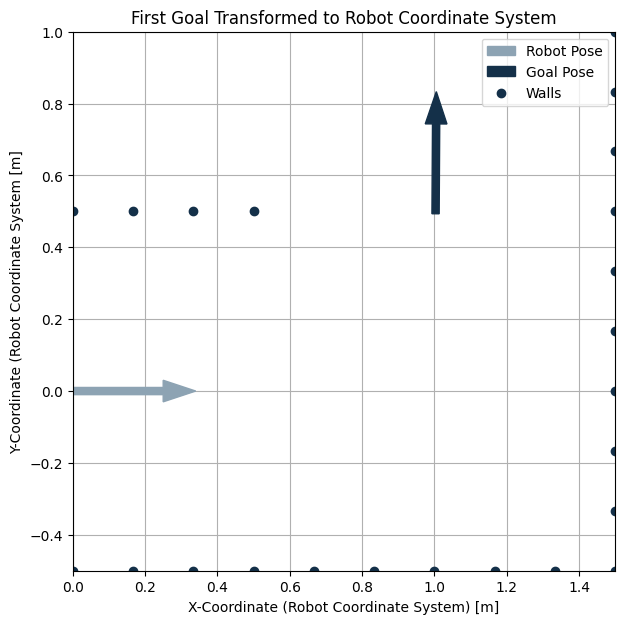

In [16]:
## Visualise transformed goal and robot poses
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Plot robot poses as arrows to indicate orientation
poses = [[0,0,0], goalpose.tolist()]
labels = ["Robot Pose", "Goal Pose"]
colours = [colourScheme["lightblue"], colourScheme["darkblue"]]

for s, l, c in zip(poses, labels, colours):
    # Calculate arrow's dx and dy from s = [x, y, theta]
    p2 = np.array([np.cos(s[2]), np.sin(s[2])])
    # Scale arrow length and draw
    p2 /= np.linalg.norm(p2)*4
    ax.arrow(s[0], s[1], p2[0], p2[1], width=0.02, label=l, color=c)

# Plot walls (from Step 1, if the variable exists)
if 'wallPositions' in locals():
    try: ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
    except: pass

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate (Robot Coordinate System) [m]")
ax.set_ylabel("Y-Coordinate (Robot Coordinate System [m]")
ax.set_title("First Goal Transformed to Robot Coordinate System")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1]
ax.set_yticks = [-1, 0, 1]
ax.set_xlim(-0, 1.5)
ax.set_ylim(-0.5, 1)

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

## Generate Valid Control Signals

Local planning works through forward simulation. This means that at each time step, various possible control signals are generated. These control signals are then applied to a simulated robot (see class 4' exercise). The resulting simulated robot trajectories are finally evaluated, whether or not they advance the robot towards its goal. From all these candidates, the best trajectory is selected and the corresponding control signal is applied to the robot.

In 2D, control signals sent to the robot to achieve movement consist of a linear velocity $vt$ and an angular velocity $wt$. A full control signal takes the form $(vt, wt)$ for the control applied at a single point in time $t$. If the control signal spans over more than one point in time, it takes the form of a list consisting of $(vt, wt)$ pairs.

The next code cell implements the `generateControls` method, that creates a list of possible $(vt, wt)$ pairs that lead the robot towards the next goal. The biggest consideration here is performance. If fewer controls are generated, forward simulation requires less performance. However, on the flip side, fewer controls mean less accuracy in reaching the goal. The general approach to generate the controls is to determine valid ranges for $v_t$ and $w_t$ respectively and then create combinations of every valid $v_t$ and $w_t$.

```python
def generateControls(lastControl: npt.ArrayLike) -> np.ndarray:
    ...
    return controls
```

The following implementation provides the last applied control as a function argument. Due to the robot's inertia, the generated control signals may not deviate to far from the last applied control.

In [17]:
# REDACTED CODE BLOCK
## Implements generateControls() method that creates valid combinations of control signals based on the last control

In [18]:
last_control = [0,0]
controls = generateControls(last_control)
print(controls)
print("---")
print(controls.shape)

[[-0.025  -1.4   ]
 [-0.0135 -1.4   ]
 [-0.002  -1.4   ]
 ...
 [ 0.0095  1.4   ]
 [ 0.021   1.4   ]
 [ 0.0325  1.4   ]]
---
(678, 2)


Even with strict velocity limits and high granularity, the resulting vector of pontential controls consists of 678 entries. If you have issues with performance, try adjusting velocity limits and granularity in this function.

## Simulate Outcome of Control Signals

Each control signal by `generateControls` is evaluated by simulating the robot driving based on the control signal. The code for robot kinematics and PT2 dynamic behaviour can be borrowed from class 4's exercise. `fowardKinematics` models how the robot pose changes when applying control signals, while `PT2Block` models the robot's inertia when applying linear velocities.

In [19]:
def forwardKinematics(control: npt.ArrayLike, lastPose: npt.ArrayLike, dt: float, dtype=np.float64) -> np.ndarray:
    """Mobile robot forward kinematics (see Thrun Probabilistic Robotics)
    """
    if not isinstance(lastPose, np.ndarray):  # Check input formatting
        lastPose = np.array(lastPose, dtype=dtype)
    assert lastPose.shape == (3,), "Wrong pose format. Pose must be provided as list or array of form [x, y, theta]"
    if not isinstance(control, np.ndarray): control = np.array(control)
    assert control.shape == (2,), "Wrong control format. Control must be provided as list or array of form [vt, wt]"
    vt, wt = control
    # Set omega to smallest possible nonzero value in case it is zero to avoid division by zero
    if wt == 0: wt = np.finfo(dtype).tiny
    vtwt = vt/wt
    _, _, theta = lastPose
    return lastPose + np.array([
        -vtwt*np.sin(theta) + vtwt*np.sin(theta + (wt*dt)),
        vtwt*np.cos(theta) - vtwt*np.cos(theta + (wt*dt)),
        wt*dt
    ], dtype=dtype)

class PT2Block:
    """Discrete PT2 Block approximated using the Tustin approximation (rough robot dynamics model)
    """
    def __init__(self, T=0, D=0, kp=1, ts=0, bufferLength=3) -> None:
        self.k1, self.k2, self.k3, self.k4, self.k5, self.k6 = 0, 0, 0, 0, 0, 0
        self.e = [0 for i in range(bufferLength)]
        self.y = [0 for i in range(bufferLength)]
        if ts != 0:  self.setConstants(T, D, kp, ts)
    #
    def setConstants(self, T, D, kp, ts) -> None:
        self.k1 = 4*T**2 + 4*D*T*ts + ts**2
        self.k2 = 2*ts**2 - 8*T**2
        self.k3 = 4*T**2 - 4*D*T*ts + ts**2
        self.k4 = kp*ts**2
        self.k5 = 2*kp*ts**2
        self.k6 = kp*ts**2
    #
    def update(self, e) -> float:    
        self.e = [e]+self.e[:len(self.e)-1] # Update buffered input and output signals
        self.y = [0]+self.y[:len(self.y)-1]
        e, y = self.e, self.y # Shorten variable names for better readability
        # Calculate output signal and return output
        y[0] = ( e[0]*self.k4 + e[1]*self.k5 + e[2]*self.k6 - y[1]*self.k2 - y[2]*self.k3 )/self.k1
        return y[0]

Before control signals can be evaluated, a cost function must be defined. The cost determines, how beneficial a control signal is in steering the robot towards its goal. The cost function takes the following three arguments.

- **pose**: Robot pose resulting from movement $\vec{x_{robot}} = (x, y, \theta)$. This value will later be predicted by the kinematics and dynamics models.
- **goalpose**: Current goal pose $\vec{x_{goal}} = (x_g, y_g, \theta_g$)
- **control**: Applied control input to arrive at*pose* $\vec{u} = (v_t, w_t)$

The arguments are passed as NumPy arrays with the two poses each being of shape `(3,)` and the control being of shape `(2,)`. The function returns a single floating point value called *cost*. A cost closer to 0 indicates the robot moving closer to its goalpose.

```python
def costFn(pose: npt.ArrayLike, goalpose: npt.ArrayLike, control: npt.ArrayLike) -> float:
    ...
    return cost
```
In order to calculate the cost, pose, goalpose and control are combined to a singular floating point value. The main concerns for this are ambiguities in the robot's rotation and correctly weighting the each value in the resulting cost.

First, the goalpose is subtracted from the robot pose to calculate the **state error**. This error indicates how close the resulting robot pose is to the goal. Ensure element-wise, that each entry of the resulting vector is positive using `np.abs()`.

$$
\vec{e} = |\vec{x_{robot}} - \vec{x_{goal}}|
$$

The **state weighting** matrix $\mathbf{Q}$ indicates, how the different components of the state error affect the final calculated cost. The ratio between the three non-zero values determines the weighted sum of each component in the final cost. The upper left value controls position error in $x$, the middle value controls position error in $y$ and the lower right value controls rotation error ($\theta$).

The values provided here are only starting points. Tune your controller after finishing the controller implementation.

$$
\mathbf{Q} = \begin{pmatrix}
1, 0, 0 \\ 0, 1, 0 \\ 0, 0, 0.5
\end{pmatrix}
$$

Similarly to the state weighting, the control inputs are also weighted and added to the cost using the **control weighting** matrix $\mathbf{R}$.

$$
\mathbf{R} = \begin{pmatrix}
0.1, 0 \\ 0, 0.1
\end{pmatrix}
$$

The final cost can be calculated using matrix multiplication. Make sure to take the absolute values of $\vec{e}$ and $\vec{u}$ and handle rotation errors that are $<-\pi$ or $>\pi$.  

$$
\vec{u} = |\vec{u}|
$$
$$
c = \vec{e}^T \cdot (\mathbf{Q} \cdot \vec{e}) + \vec{u}^T \cdot (\mathbf{R} \cdot \vec{u})
$$

In [20]:
# REDACTED CODEBLOCK
## Implements costFn function that evaluates control signals

For each control signal candidate, the resulting goalstate can now be calculated by starting the robot at `[0,0,0]`, applying `PT2Block.update` to the linear velocity $v_t$ and applying the resulting velocities to `fowardKinematics`.

This simulation is performed at certain discrete time-steps, spaced apart by a **sampling time** `ts`. The **horizon** determines, how many time-steps are simulated.

The next cell performs forward simulation for the robot and goal poses presented in the last visualisation using our generated controls and the previously implemented cost function. Simulation is performed over 70 time-steps to properly visualise the simulated path. However, in order to achieve a real-time capable controller, the final implementation will most likely simulate for significantly fewer time steps.

In [21]:
import copy

def evaluateControls(controls, robotModelPT2, horizon):
    costs = np.zeros_like(np.array(controls)[:,0], dtype=float)
    trajectories = [ [] for _ in controls ]
    
    # Apply range of control signals and compute outcomes
    for ctrl_idx, control in enumerate(controls):
    
        # Copy currently predicted robot state
        forwardSimPT2 = copy.deepcopy(robotModelPT2)
        forwardpose = [0,0,0]
    
        # Simulate until horizon
        for step in range(horizon):
            control_sim = copy.deepcopy(control)
            v_t, w_t = control
            v_t_dynamic = forwardSimPT2.update(v_t)
            control_dym = [v_t_dynamic, w_t]
            forwardpose = forwardKinematics(control_dym, forwardpose, ts)
            costs[ctrl_idx] += costFn(forwardpose, goalpose, control_sim)
            # Track trajectory for visualisation
            trajectories[ctrl_idx].append(forwardpose)

    return costs, trajectories

ts = 1/2 # Sampling time [sec] -> 2Hz
horizon = 10 # Number of time steps to simulate. 10*0.5 sec = 5 seconds lookahead into the future
robotModelPT2 = PT2Block(ts=ts, T=0.05, D=0.8)
costs, trajectories = evaluateControls(controls, robotModelPT2, 70) # -> We sample 70 control updates here to make the visualisation later prettier. This is too slow for actual control

The next cell visualises the current robot and goal poses alongside all trajectories resulting from the evaluated control signals. The trajectories are shaded to indicate the resulting cost, with lower cost (=better) causing a darker line.

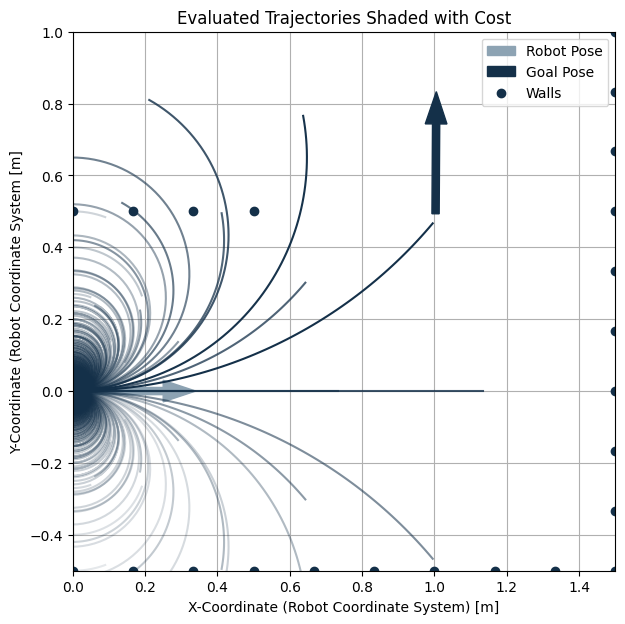

In [22]:
## Visualise transformed goal and robot poses
# Create single figure
plt.rcParams['figure.figsize'] = [7, 7]
fig, ax = plt.subplots()

# Plot robot poses as arrows to indicate orientation
poses = [[0,0,0], goalpose.tolist()]
labels = ["Robot Pose", "Goal Pose"]
colours = [colourScheme["lightblue"], colourScheme["darkblue"]]

for s, l, c in zip(poses, labels, colours):
    # Calculate arrow's dx and dy from s = [x, y, theta]
    p2 = np.array([np.cos(s[2]), np.sin(s[2])])
    # Scale arrow length and draw
    p2 /= np.linalg.norm(p2)*4
    ax.arrow(s[0], s[1], p2[0], p2[1], width=0.02, label=l, color=c)

# Plot walls (from Step 1, if the variable exists)
if 'wallPositions' in locals():
    try: ax.scatter(wallPositions[:,1], wallPositions[:,0], c=colourScheme["darkblue"], alpha=1.0, s=6**2, label="Walls")
    except: pass

# Plot trajectories and shade with costs
costs_scaled = (costs - costs.min())/(costs.max() - costs.min()) # Scales cost from 0-1 and emphasises low costs
costs_inverted = 1-costs_scaled
costs_emphasis = np.exp(3*costs_inverted-3)

for traj, cost in zip(trajectories, costs_emphasis):
    traj = np.array(traj)
    ax.plot(traj[:,0], traj[:,1], c=colourScheme["darkblue"], alpha=(cost))

# Set axes labels and figure title
ax.set_xlabel("X-Coordinate (Robot Coordinate System) [m]")
ax.set_ylabel("Y-Coordinate (Robot Coordinate System [m]")
ax.set_title("Evaluated Trajectories Shaded with Cost")

# Set grid to only plot each metre
ax.set_xticks = [-1, 0, 1]
ax.set_yticks = [-1, 0, 1]
ax.set_xlim(-0, 1.5)
ax.set_ylim(-0.5, 1)

# Move grid behind points
ax.set_axisbelow(True)
ax.grid()

# Add labels
ax.legend()

# Show plot
plt.show()

`evaluateControls` returns resulting costs and trajectories both in a list of the same length as the generated controls.

The next cell finds the index of the lowest (=best) value in `costs` and retrieves the corresponding value from the `trajectories` and `controls` lists.

In [23]:
# REDACTED CODEBLOCK
## Finds idx in costs vector and reads the corresponding entry in trajectories and controls

In [24]:
print(f"Index with lowest cost: {idx}")
print(f"Resulting cost: {costs[idx]}")
print(f"Resulting control: {controls[idx]}")

Index with lowest cost: 347
Resulting cost: 32.92503771200057
Resulting control: [0.0325 0.025 ]


## Publish to ROS

The last step required to actually perform local planning is to connect the controller to the simulated robot in ROS. The `localiseRobot()` method already loads our feedback signal. To make the robot move, the control resulting in the lowest cost needs to be published to the `\cmd_vel` topic as a *geometry_msgs/Twist* message.

To achieve the visualisation shown in Moodle, the following values need to be published:

- **Trajectory**: The trajectory resulting in the lowest cost as a *nav_msgs/Path* message.
- **Goalpose**: The transformed goalpose in the `base_link` coordinate system (=relative to the robot) as a *geometry_msgs/PoseStamped* message.

In [25]:
# REDACTED CODEBLOCK
# Implements publishing of control (cmd_vel), trajectory and the current goal

The next cell publishes the goalpose as well as control and trajectory resulting in the lowest cost to the simulated robot in ROS unsing convenience funcitons implemented in the last cell.

In [26]:
#pubCMD(controls[idx]) # <- Uncomment to make the robot move
pubTrajectory(trajectories[idx])
pubGoal(goalpose) 

## Putting everything together

The final step is to put all components into one loop. The final loop must perform the following steps:

1. Localise the robot
2. Select the current goalpose in the global path
3. Generate control signals
4. Perform forward simulation
5. Select control signal resulting in lowest cost
6. Publish control, goalpose and trajectory to ROS

Do not forget to send a control of $(0,0)$ upon reaching the last goalpose to stop the robot.

In [27]:
# REDACTED CODEBLOCK
## Combines previously implemented functions into one control loop


Goal changed!
Goal changed!
Goal changed!
Goal changed!
Goal changed!
Goal changed!
Goal changed!
